# Validation Set with Manual Review
This notebook contains the implementation and evaluation of various neural network models with differing paremeters.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%aimport manual_review_classifier

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from manual_review_classifier.ClassifierPlots import create_reliability_diagram, create_roc_curve, create_feature_importance_plot, make_model_output_plot
from manual_review_classifier.Analysis import determine_feature_importance, print_accuracy_and_classification_report, predict_classes, get_somatic_error_type, calculate_kappa
from zero_one_based_conversion import convert
from manual_review_classifier.ReadCount import ReadCount

pd.set_option('display.max_colwidth', -1)

sns.set_style("white")
sns.set_context('talk')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

Using TensorFlow backend.
/Users/ebarnell/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
# Pull in training data
training_data = pd.read_pickle('../data/training_data.pkl')

In [5]:
# Remove AML31 case
# aml31_training = training_data[training_data.index.str.contains('H_KA-452198')]
# training_data = training_data[~training_data.index.str.contains('H_KA-452198')]

In [6]:
#REMOVE IF FAIL pd.read_csv('output_list.txt', sep=" ", header=None)
# training_data = pd.read_csv('/Users/ebarnell/Desktop/final_df.txt', sep='\t', index_col=[0])

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Set parameters for cross-validation fold splits
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

# Re-label the germline calls as failed calls
three_class = training_data.replace('g','f')
three_class.sort_index(axis=1, inplace=True)

In [7]:
s_v_b = three_class
s_v_b['solid_tumor'] = s_v_b[['disease_GST', 'disease_MPNST', 'disease_SCLC',
                              'disease_breast', 'disease_colorectal', 
                              'disease_glioblastoma', 'disease_melanoma']].apply(any, axis=1).astype(int)
s_v_b.drop(['disease_AML', 'disease_GST', 'disease_MPNST', 'disease_SCLC',
       'disease_breast', 'disease_colorectal', 'disease_glioblastoma',
       'disease_lymphoma', 'disease_melanoma'], axis=1, inplace=True)

In [8]:
# Get Labels
Y = pd.get_dummies(three_class.call).astype(float).values
# Get training data as numpy array, remove reviews because of non overlap
s_v_b = s_v_b.drop(['call', 'reviewer_1',
                'reviewer_2', 'reviewer_3', 
                'reviewer_4'], axis=1)
X = s_v_b.sort_index(axis=1).astype(float).values

In [9]:
X.shape

(41832, 59)

In [10]:
Y.shape

(41832, 3)

In [11]:
# define baseline model
def model():
    # create model
    model = Sequential()
    model.add(Dense(59, input_dim=59, kernel_initializer='normal', activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [12]:
estimator = KerasClassifier(build_fn=model, epochs=1000, batch_size=2000, verbose=0)

In [13]:
estimator.fit(X, Y)

# Prepare Data

In [14]:
def parse_samples_file(samples_file_path, header):
    
    with open(samples_file_path) as f:
        samples = f.readlines()
        samples = [x.strip() for x in samples]
        samples = [x.split('\t') for x in samples]
        if header:
            samples.pop(0)
    return samples

def run_bam_readcount(skip_readcount, out_dir_path, samples, name):
    out_dir_path = os.path.join(out_dir_path, 'readcounts')
    if not os.path.exists(out_dir_path):
        os.makedirs(out_dir_path)
    review = pd.DataFrame(columns=['chromosome', 'start', 'stop',
                                        'ref', 'var', 'call', 'reviewer'])
    for sample in samples:
        print('-----------------------------------------------------'
              '\nStarting on sample {0}\n'.format(sample[0]))
        reviewer_specified_in_sample = False
        sites_file_path = os.path.join(out_dir_path, sample[0] + '.sites')
        review = parse_review_file(sample[3], sites_file_path,
                                         sample[0])
        reviewer_in_bed_file = 'reviewer' in review.columns
        review['disease'] = sample[4]
        review = pd.concat([review, review], ignore_index=True)
        bed_one_based_f_path = sample[3] + '.one_based'
        print('Processing tumor bam file:\n\t{0}'.format(sample[1]))
        tumor_readcount_file_path = '{0}/{1}_tumor' \
                                    '.readcounts'.format(out_dir_path,
                                                         sample[0])
        if not skip_readcount:
            os.system('bam-readcount -i -w 0 -l {0} -f {1} '
                      '{2} > {3}'.format(sites_file_path, sample[5],
                                         sample[1],
                                         tumor_readcount_file_path))

        tumor_rc = ReadCount(tumor_readcount_file_path)

        tumor_data = tumor_rc.compute_variant_metrics(bed_one_based_f_path,
                                                      'tumor',
                                                      reviewer_in_bed_file,
                                                      sample[5])
        print('Processing normal bam file:\n\t{0}'.format(sample[2]))
        normal_readcount_file_path = '{0}/{1}_normal' \
                                     '.readcounts'.format(out_dir_path,
                                                          sample[0])
        if not skip_readcount:
            os.system('bam-readcount -i -w 0 -l {0} -f {1} '
                      '{2} > {3}'.format(sites_file_path, sample[5],
                                         sample[2],
                                         normal_readcount_file_path))
        normal_rc = ReadCount(normal_readcount_file_path)
        normal_data = normal_rc.\
            compute_variant_metrics(bed_one_based_f_path, 'normal',
                                    reviewer_in_bed_file, sample[5])
        if len(tumor_data) != len(normal_data):
            raise ValueError(
                'Dataframes cannot be merged. They are differing lengths.')
        else:
            individual_df = pd.merge(tumor_data, normal_data,
                                     on=['chromosome', 'start', 'stop',
                                         'ref', 'var', 'call', 'disease'])
        individual_df.index = (sample[0] + '~' + individual_df.chromosome +
                               ':' + individual_df.start.map(str) + '-' +
                               individual_df.stop.map(str) +
                               individual_df.ref + '>' +
                               individual_df['var'])
        training_data = pd.DataFrame()
        training_data = pd.concat([training_data, individual_df])

    training_data.drop(['chromosome', 'start', 'stop', 'ref', 'var'],
                            axis=1, inplace=True)
    #perform_one_hot_encoding('disease', training_data)
    calls = training_data.pop('call')

    # normalize continuous variables
    columns = ['normal_VAF', 'normal_depth', 'normal_other_bases_count',
               'normal_ref_avg_basequality',
               'normal_ref_avg_clipped_length',
               'normal_ref_avg_distance_to_effective_3p_end',
               'normal_ref_avg_distance_to_q2_start_in_q2_reads',
               'normal_ref_avg_mapping_quality',
               'normal_ref_avg_num_mismaches_as_fraction',
               'normal_ref_avg_pos_as_fraction',
               'normal_ref_avg_se_mapping_quality',
               'normal_ref_avg_sum_mismatch_qualities', 'normal_ref_count',
               'normal_ref_num_minus_strand', 'normal_ref_num_plus_strand',
               'normal_ref_num_q2_containing_reads',
               'normal_var_avg_basequality',
               'normal_var_avg_clipped_length',
               'normal_var_avg_distance_to_effective_3p_end',
               'normal_var_avg_distance_to_q2_start_in_q2_reads',
               'normal_var_avg_mapping_quality',
               'normal_var_avg_num_mismaches_as_fraction',
               'normal_var_avg_pos_as_fraction',
               'normal_var_avg_se_mapping_quality',
               'normal_var_avg_sum_mismatch_qualities', 'normal_var_count',
               'normal_var_num_minus_strand', 'normal_var_num_plus_strand',
               'normal_var_num_q2_containing_reads', 'tumor_VAF',
               'tumor_depth',
               'tumor_other_bases_count', 'tumor_ref_avg_basequality',
               'tumor_ref_avg_clipped_length',
               'tumor_ref_avg_distance_to_effective_3p_end',
               'tumor_ref_avg_distance_to_q2_start_in_q2_reads',
               'tumor_ref_avg_mapping_quality',
               'tumor_ref_avg_num_mismaches_as_fraction',
               'tumor_ref_avg_pos_as_fraction',
               'tumor_ref_avg_se_mapping_quality',
               'tumor_ref_avg_sum_mismatch_qualities', 'tumor_ref_count',
               'tumor_ref_num_minus_strand', 'tumor_ref_num_plus_strand',
               'tumor_ref_num_q2_containing_reads',
               'tumor_var_avg_basequality',
               'tumor_var_avg_clipped_length',
               'tumor_var_avg_distance_to_effective_3p_end',
               'tumor_var_avg_distance_to_q2_start_in_q2_reads',
               'tumor_var_avg_mapping_quality',
               'tumor_var_avg_num_mismaches_as_fraction',
               'tumor_var_avg_pos_as_fraction',
               'tumor_var_avg_se_mapping_quality',
               'tumor_var_avg_sum_mismatch_qualities', 'tumor_var_count',
               'tumor_var_num_minus_strand', 'tumor_var_num_plus_strand',
               'tumor_var_num_q2_containing_reads']
    to_normalize = training_data[columns]
    x = to_normalize.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    scaled = pd.DataFrame(x_scaled, index=training_data.index,
                          columns=columns)
    training_data.to_pickle(os.path.join(out_dir_path, name + 'train.pkl'))
    calls.to_pickle(os.path.join(out_dir_path, name + 'call.pkl'))

def perform_one_hot_encoding(column, training_data):
    """perform one-hot encoding on categorical variables

        Args:
            column (str): Column name to perform encoding on

    """
    get_dummies = pd.get_dummies(training_data[column], prefix=column)
    categorical_columns = list()
    categorical_columns += get_dummies.columns.values.tolist()
    training_data = pd.concat([training_data, get_dummies],
                                   axis=1)
    training_data.drop(column, axis=1, inplace=True)

def parse_review_file(manual_review_file_path, sites_file_path,
                       sample_name):
    manual_review = pd.read_csv(manual_review_file_path, sep='\t')
    manual_review.columns = map(str.lower, manual_review.columns)
    manual_review.rename(columns={'reference': 'ref', 'variant': 'var'},
                         inplace=True)
    manual_review = manual_review[['chromosome', 'start', 'stop',
                                       'ref', 'var', 'call']]
    manual_review = manual_review.apply(convert_one_based, axis=1)
    manual_review = manual_review.replace('', np.nan).dropna(how='all')
    manual_review[['chromosome', 'start', 'stop']].to_csv(sites_file_path,
                                                          sep='\t',
                                                          index=False,
                                                          header=False)
    manual_review.to_csv(manual_review_file_path+'.one_based', sep='\t',
                         index=False, header=True)
    return manual_review

def convert_one_based(row):
    return convert.coordinate_system('\t'.join(map(str, row.values)),
                                     'to_one_based').strip().split('\t')



In [23]:
# Create Breast pkl file

samples_file_path = '/Users/ebarnell/DeepSVR/deepsvr/data/samples.noheader.tsv'
header = False
out_dir_path = '/Users/ebarnell/DeepSVR/data/independent_test/'
skip_readcount = False
name = 'test_'

samples = parse_samples_file(samples_file_path, header)
run_bam_readcount(skip_readcount, out_dir_path, samples, name)

-----------------------------------------------------
Starting on sample tst1

Processing tumor bam file:
	/Users/ebarnell/DeepSVR/deepsvr/data/tst1.exome.tumor.bam
Processing normal bam file:
	/Users/ebarnell/DeepSVR/deepsvr/data/tst1.exome.normal.bam


# SCLC Holdout Test Set

In [15]:
sclc_data = pd.read_pickle('../data/independent_test/sclc_train.pkl')
sclc_data = sclc_data.drop(['disease_SCLC', 'reviewer_Lee'], axis=1)
sclc_data['solid_tumor'] = 1

In [16]:
sclc_call = pd.read_pickle('../data/independent_test/sclc_call.pkl')
sclc_call=sclc_call.map(str.lower).replace('g','f').replace('s\x03', 's').replace('', 'f')
sclc_call.value_counts()

s    5471
a    297 
f    274 
Name: call, dtype: int64

In [17]:
# Get Labels
sclc_Y = pd.get_dummies(sclc_call).astype(float).values
# Get training data as numpy array
sclc_X = sclc_data.sort_index(axis=1).astype(float).values

In [18]:
sclc_probs = estimator.predict_proba(sclc_X)

In [19]:
sclc_probs[70]

array([  2.93635670e-02,   3.62330058e-04,   9.70274150e-01], dtype=float32)

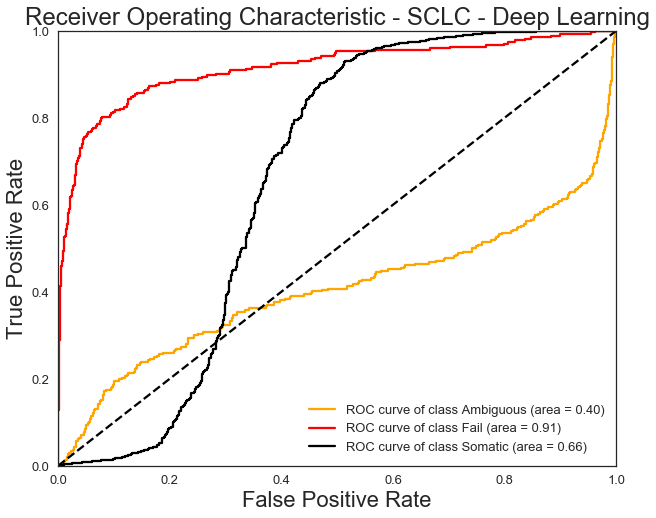

In [20]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(sclc_Y, sclc_probs, class_lookup, 
                 'ROC - SCLC - Deep Learning', ax)
ax.set_ylabel('True Positive Rate', fontsize=22)
ax.set_xlabel('False Positive Rate', fontsize=22)
ax.set_title('Receiver Operating Characteristic - SCLC - Deep Learning', fontsize=24)
fig.set_size_inches(10, 8)
savefig('/Users/ebarnell/Desktop/Illustrator/figures/Classifier/SCLC_ROC.png', bbox_inches='tight', dpi=1000)

In [ ]:
seed = 7
sclc_auc = []

for i in np.arange(0, 0.8, 0.05):
    if i == 0:
        sclc_X_sclc = sclc_X
        sclc_Y_sclc = sclc_Y
        X_train = X
        Y_train = Y
    else:
        (sclc_X_train, sclc_X_sclc, 
         sclc_Y_train, sclc_Y_sclc) = train_test_split(sclc_X, sclc_Y, 
                                                       train_size=i,
                                                       random_state=seed, 
                                                       stratify=sclc_Y) 
        X_train = np.concatenate((X, sclc_X_train))
        Y_train = np.concatenate((Y, sclc_Y_train))
    print('Percentage of test data included in training: ', i*100)
    print('Training data shape: ', X_train.shape)
    print('Test data shape: ', sclc_X_sclc.shape)
    print('Number of test samples included in training: ', X_train.shape[0]-X.shape[0])
    estimator.fit(X_train, Y_train)
    X_sclc_probs = estimator.predict_proba(sclc_X_sclc)
    print_accuracy_and_classification_report(sclc_Y_sclc, predict_classes(X_sclc_probs))
    temp_auc = []
    temp_auc.append(X_train.shape[0]-X.shape[0])
    for j in range(Y.shape[1]):
        temp_auc.append(metrics.roc_auc_score(sclc_Y_sclc[:, j], X_sclc_probs[:, j]))
    sclc_auc.append(temp_auc)
    print('Test AUC: ', temp_auc)
    print('---------------------------------------------------------')

Percentage of test data included in training:  0.0
Training data shape:  (41832, 59)
Test data shape:  (6042, 59)
Number of test samples included in training:  0


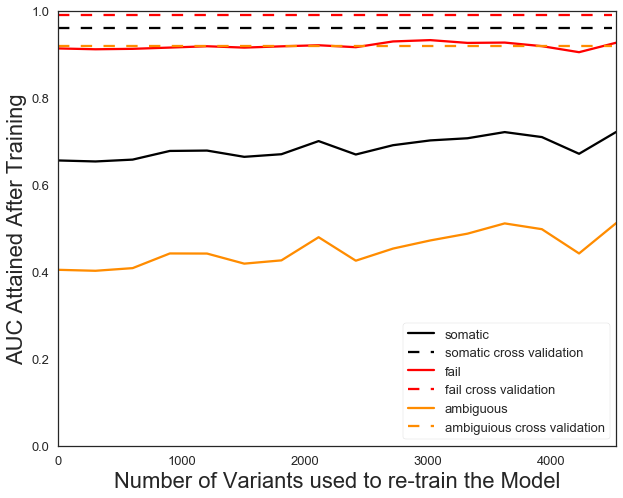

In [55]:
sclc_auc = pd.DataFrame(sclc_auc, columns=['num. SCLC variants in training','ambiguous', 'fail','somatic'])
sclc_auc.to_pickle('../data/deep_learning/sclc_batch_effect_correction.pkl')
# sclc_auc = pd.read_pickle('../data/deep_learning/sclc_batch_effect_correction.pkl')


fig, ax = plt.subplots(1, 1)
sclc_auc.plot(x='num. SCLC variants in training', y='somatic', ax=ax, color='black')
ax.plot([0, 4500], [.96,.96], linestyle='--', dashes=(5, 5),color='black', label='somatic cross validation')
sclc_auc.plot(x='num. SCLC variants in training', y='fail', ax=ax, color='red')
ax.plot([0, 4500], [.99,.99], linestyle='--', dashes=(5, 5),color='red', label='fail cross validation')
sclc_auc.plot(x='num. SCLC variants in training', y='ambiguous', ax=ax, color='darkorange')
ax.plot([0, 4500], [.92,.92], linestyle='--', dashes=(5, 5),color='darkorange', label='ambiguious cross validation')
ax.set_ylim([0,1.0])
ax.set_ylabel('AUC Attained After Training', fontsize=22)
ax.set_xlabel('Number of Variants used to re-train the Model', fontsize=22)
ax.set_title('', fontsize=24)
ax.legend(loc=4,frameon=True)
fig.set_size_inches(10, 8)
savefig('/Users/ebarnell/Desktop/Illustrator/figures/Classifier/SCLC_batch.png', bbox_inches='tight', dpi=1000)

# Breast Test Set

In [23]:
breast_data = pd.read_pickle('../data/independent_test/readcounts/test_train.pkl')
breast_data = breast_data.drop(['disease'], axis=1)
breast_data['solid_tumor'] = 1

In [24]:
breast_call = pd.read_pickle('../data/independent_test/readcounts/test_call.pkl')
breast_call = breast_call.map(str.lower).replace('g','f').replace('s\x03', 's').replace('', 'f')
breast_call.value_counts()

s    284
a    92 
f    67 
Name: call, dtype: int64

In [25]:
# Get Labels
breast_Y = pd.get_dummies(breast_call).astype(float).values
# Get training data as numpy array
breast_X = breast_data.sort_index(axis=1).astype(float).values

In [26]:
breast_probs = estimator.predict_proba(breast_X)

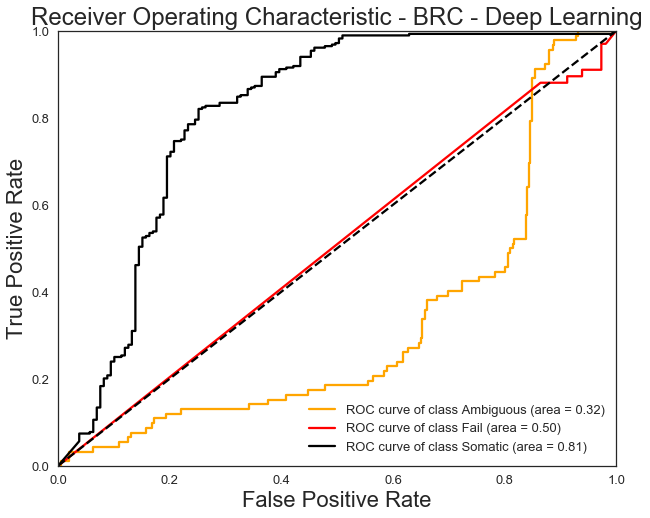

In [27]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(breast_Y, breast_probs, class_lookup, 
                 'Receiver Operating Characteristic - BRC - Deep Learning', ax)
ax.set_ylabel('True Positive Rate', fontsize=22)
ax.set_xlabel('False Positive Rate', fontsize=22)
ax.set_title('Receiver Operating Characteristic - BRC - Deep Learning', fontsize=24)
fig.set_size_inches(10, 8)
savefig('/Users/ebarnell/Desktop/Illustrator/figures/Classifier/Breast_ROC.png', bbox_inches='tight', dpi=1000)

In [31]:
seed = 7
auc = []

for i in np.arange(0, 0.8, 0.05):
    if i == 0:
        breast_X_breast = breast_X
        breast_Y_breast = breast_Y
        X_train = X
        Y_train = Y
    else:
        (breast_X_train, breast_X_breast, 
         breast_Y_train, breast_Y_breast) = train_test_split(breast_X, breast_Y, 
                                                       train_size=i,
                                                       random_state=seed, 
                                                       stratify=breast_Y) 
        X_train = np.concatenate((X, breast_X_train))
        Y_train = np.concatenate((Y, breast_Y_train))
    print('Percentage of test data included in training: ', i*100)
    print('Training data shape: ', X_train.shape)
    print('Test data shape: ', breast_X_breast.shape)
    print('Number of test samples included in training: ', X_train.shape[0]-X.shape[0])
    estimator.fit(X_train, Y_train)
    X_breast_probs = estimator.predict_proba(breast_X_breast)
    print_accuracy_and_classification_report(breast_Y_breast, predict_classes(X_breast_probs))
    temp_auc = []
    temp_auc.append(X_train.shape[0]-X.shape[0])
    for j in range(Y.shape[1]):
        temp_auc.append(metrics.roc_auc_score(breast_Y_breast[:, j], X_breast_probs[:, j]))
    auc.append(temp_auc)
    print('Test AUC: ', temp_auc)
    print('---------------------------------------------------------')

Percentage of test data included in training:  0.0
Training data shape:  (41832, 59)
Test data shape:  (443, 59)
Number of test samples included in training:  0
Cross validation accuracy:
	 0.641083521445

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        92
          1       0.00      0.00      0.00        67
          2       0.65      1.00      0.79       284

avg / total       0.42      0.64      0.51       443

Test AUC:  [0, 0.44881085098476409, 0.8600746268656716, 0.56289308176100628]
---------------------------------------------------------
Percentage of test data included in training:  5.0
Training data shape:  (41854, 59)
Test data shape:  (421, 59)
Number of test samples included in training:  22


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Cross validation accuracy:
	 0.650831353919

Cross validation classification report

             precision    recall  f1-score   support

          0       0.33      0.56      0.42        87
          1       0.79      0.41      0.54        64
          2       0.83      0.74      0.78       270

avg / total       0.72      0.65      0.67       421

Test AUC:  [22, 0.67396241998761108, 0.94270833333333337, 0.80944321805248953]
---------------------------------------------------------
Percentage of test data included in training:  10.0
Training data shape:  (41876, 59)
Test data shape:  (399, 59)
Number of test samples included in training:  44
Cross validation accuracy:
	 0.684210526316

Cross validation classification report

             precision    recall  f1-score   support

          0       0.55      0.14      0.23        83
          1       0.51      0.72      0.60        60
          2       0.74      0.85      0.79       256

avg / total       0.67      0.68      0.65      

Cross validation accuracy:
	 0.729323308271

Cross validation classification report

             precision    recall  f1-score   support

          0       0.46      0.75      0.57        28
          1       0.80      0.40      0.53        20
          2       0.88      0.80      0.84        85

avg / total       0.78      0.73      0.74       133

Test AUC:  [310, 0.76020408163265307, 0.77300884955752203, 0.86176470588235288]
---------------------------------------------------------
Percentage of test data included in training:  75.0
Training data shape:  (42164, 59)
Test data shape:  (111, 59)
Number of test samples included in training:  332
Cross validation accuracy:
	 0.801801801802

Cross validation classification report

             precision    recall  f1-score   support

          0       0.65      0.48      0.55        23
          1       0.73      0.65      0.69        17
          2       0.85      0.94      0.89        71

avg / total       0.79      0.80      0.79    

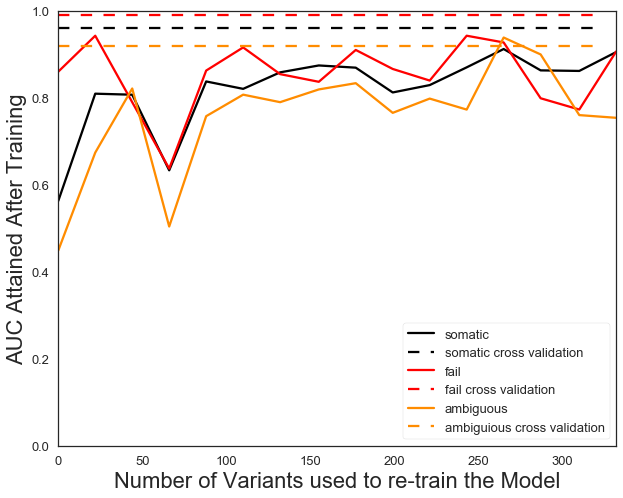

In [32]:
test_auc = pd.DataFrame(auc, columns=['num. Breast variants in training','ambiguous', 'fail','somatic'])
test_auc.to_pickle('../data/deep_learning/breast_batch_effect_correction.pkl')
# test_auc = pd.read_pickle('../data/deep_learning/breast_batch_effect_correction.pkl')

fig, ax = plt.subplots(1, 1)
test_auc.plot(x='num. Breast variants in training', y='somatic', ax=ax, color='black')
ax.plot([0, 324], [.96,.96], linestyle='--', dashes=(5, 5),color='black', label='somatic cross validation')
test_auc.plot(x='num. Breast variants in training', y='fail', ax=ax, color='red')
ax.plot([0, 324], [.99,.99], linestyle='--', dashes=(5, 5),color='red', label='fail cross validation')
test_auc.plot(x='num. Breast variants in training', y='ambiguous', ax=ax, color='darkorange')
ax.plot([0, 324], [.92,.92], linestyle='--', dashes=(5, 5),color='darkorange', label='ambiguious cross validation')
ax.set_ylim([0,1.0])
ax.set_ylabel('AUC Attained After Training', fontsize=22)
ax.set_xlabel('Number of Variants used to re-train the Model', fontsize=22)
ax.set_title('', fontsize=24)
ax.legend(loc=4,frameon=True)
fig.set_size_inches(10, 8)
savefig('/Users/ebarnell/Desktop/Illustrator/figures/Classifier/Breast_batch.png', bbox_inches='tight', dpi=1000)

# Folicular Lymphoma

In [26]:
fl_data = pd.read_pickle('../data/independent_test/fl_train.pkl')
fl_data = fl_data.drop(['disease_FL'], axis=1)
fl_data = fl_data.drop(['reviewer_NA'], axis=1)
fl_data['solid_tumor'] = 0

In [27]:
fl_call = pd.read_pickle('../data/independent_test/fl_call.pkl')
fl_call = fl_call.map(str.lower).replace('g','f').replace('s\x03', 's').replace('', 'f')
fl_call.value_counts()

s    865
f    858
Name: call, dtype: int64

In [31]:
fl_Y = pd.get_dummies(fl_call)

In [37]:
# Get Labels
fl_Y = pd.get_dummies(fl_call)
fl_Y['a'] = 0
fl_Y= fl_Y[['a', 'f', 's']].astype(float).values
# Get training data as numpy array
fl_X = fl_data.sort_index(axis=1).astype(float).values

In [34]:
fl_probs = estimator.predict_proba(fl_X)

/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:547: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


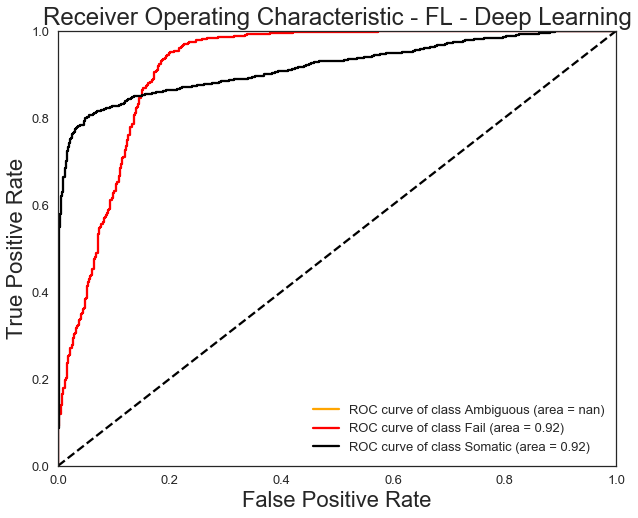

In [38]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(fl_Y, fl_probs, class_lookup, 
                 'Receiver Operating Characteristic - FL - Deep Learning', ax)
ax.set_ylabel('True Positive Rate', fontsize=22)
ax.set_xlabel('False Positive Rate', fontsize=22)
ax.set_title('Receiver Operating Characteristic - FL - Deep Learning', fontsize=24)
fig.set_size_inches(10, 8)
savefig('/Users/ebarnell/Desktop/Illustrator/figures/Classifier/FL_ROC.png', bbox_inches='tight', dpi=1000)

Percentage of fl data included in training:  0.0
Training data shape:  (41832, 59)
Fl data shape:  (1723, 59)
Number of FL variants included in training:  0


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:547: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


---------------------------------------------------------


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Percentage of fl data included in training:  5.0
Training data shape:  (41918, 59)
Fl data shape:  (1637, 59)
Number of FL variants included in training:  86
---------------------------------------------------------
Percentage of fl data included in training:  10.0
Training data shape:  (42004, 59)
Fl data shape:  (1551, 59)
Number of FL variants included in training:  172
---------------------------------------------------------
Percentage of fl data included in training:  15.0
Training data shape:  (42090, 59)
Fl data shape:  (1465, 59)
Number of FL variants included in training:  258
---------------------------------------------------------
Percentage of fl data included in training:  20.0
Training data shape:  (42176, 59)
Fl data shape:  (1379, 59)
Number of FL variants included in training:  344
---------------------------------------------------------
Percentage of fl data included in training:  25.0
Training data shape:  (42262, 59)
Fl data shape:  (1293, 59)
Number of FL varian

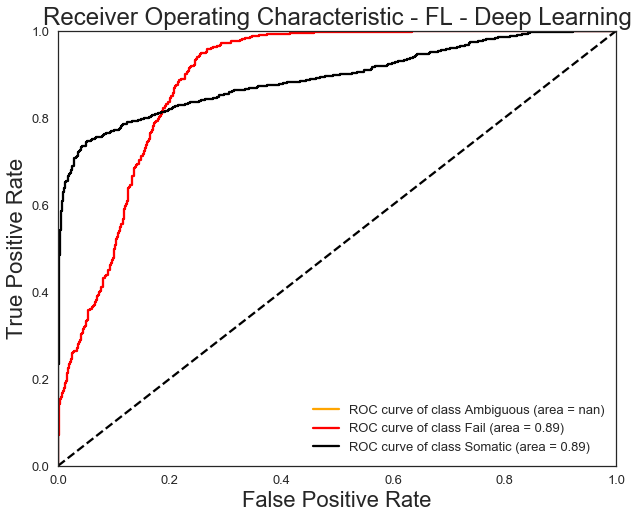

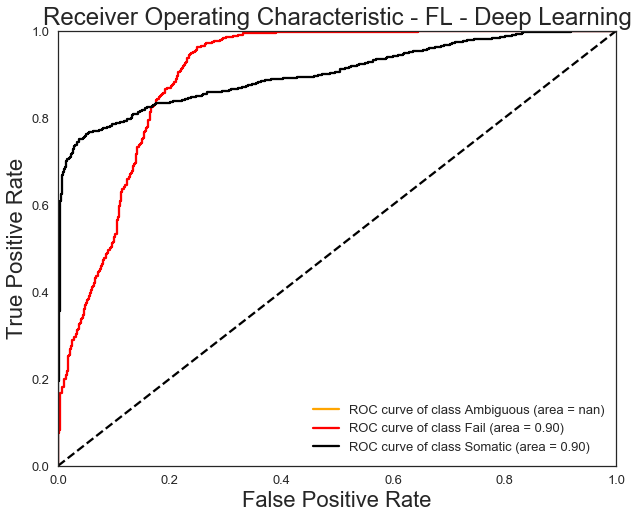

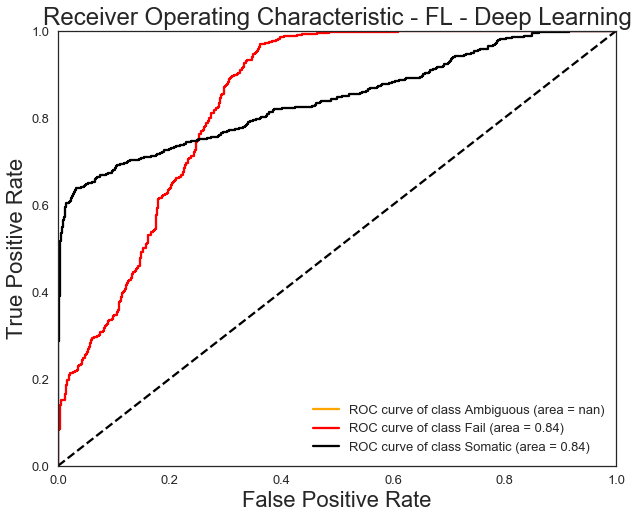

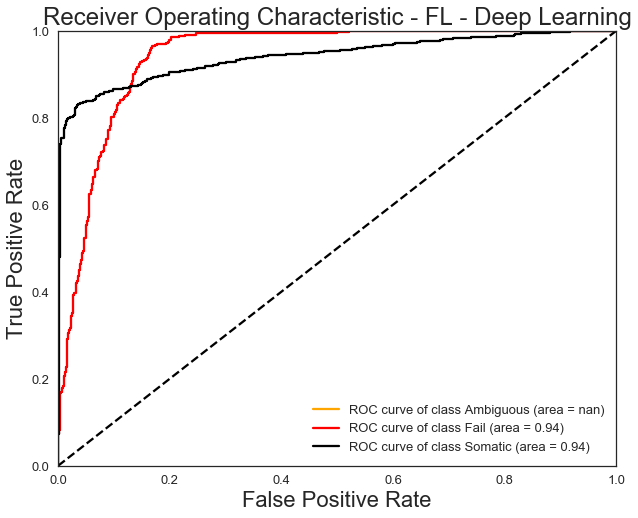

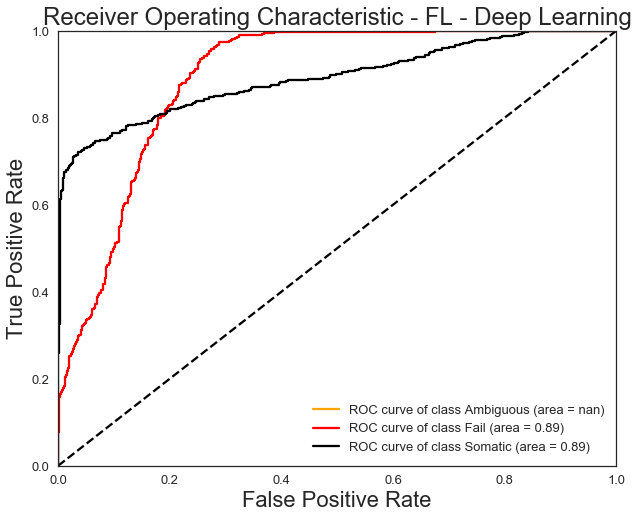

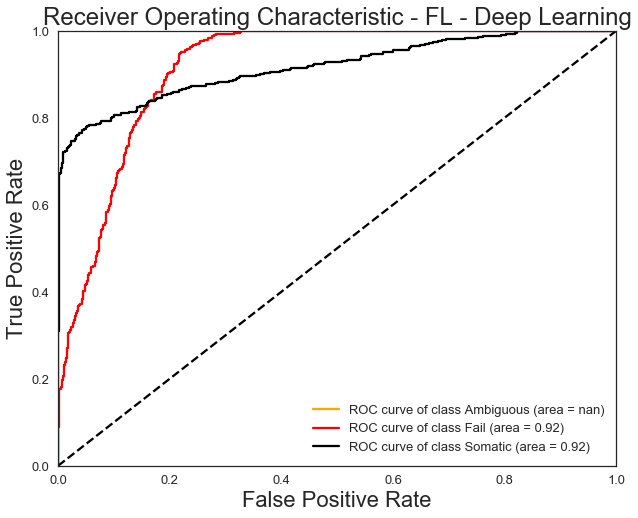

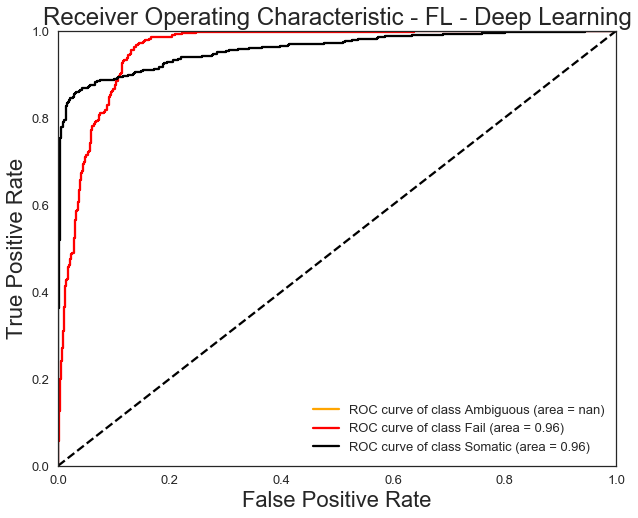

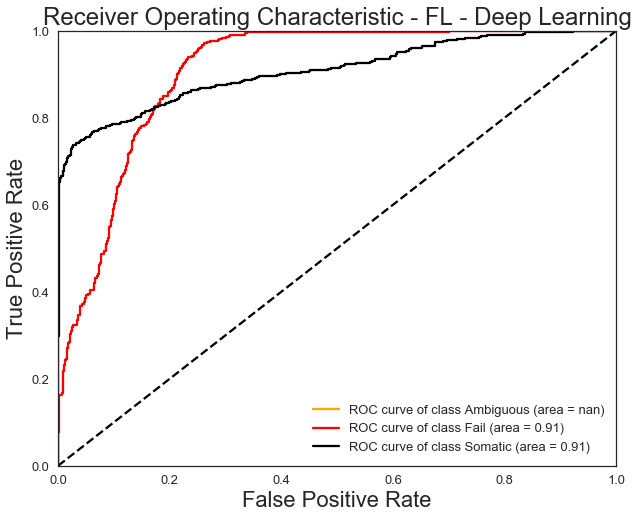

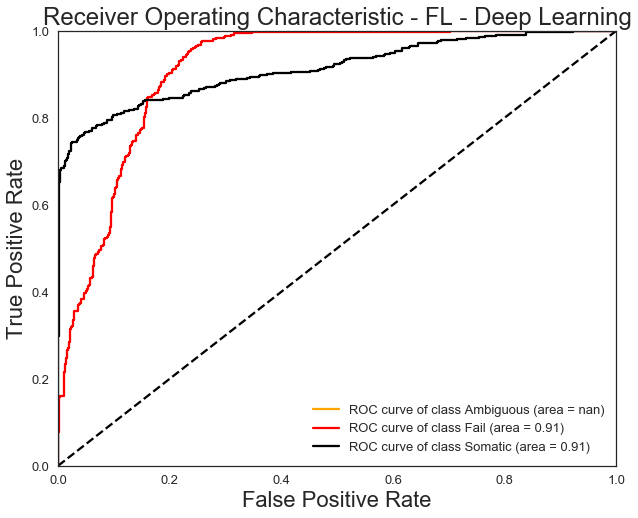

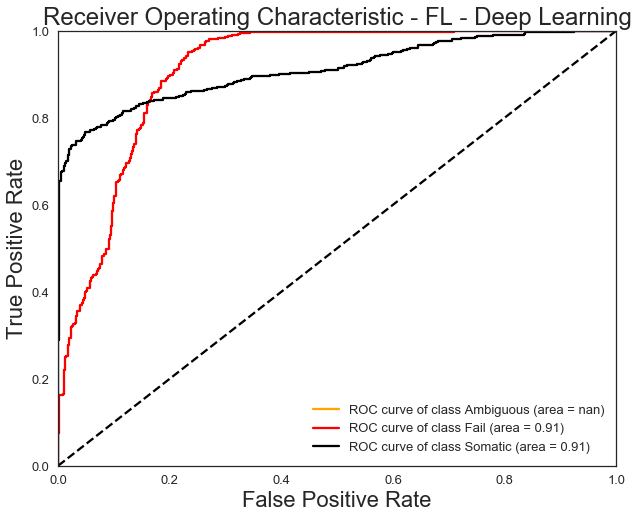

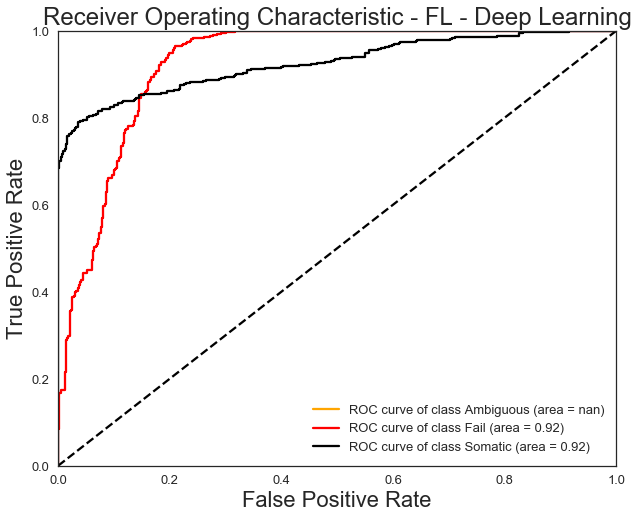

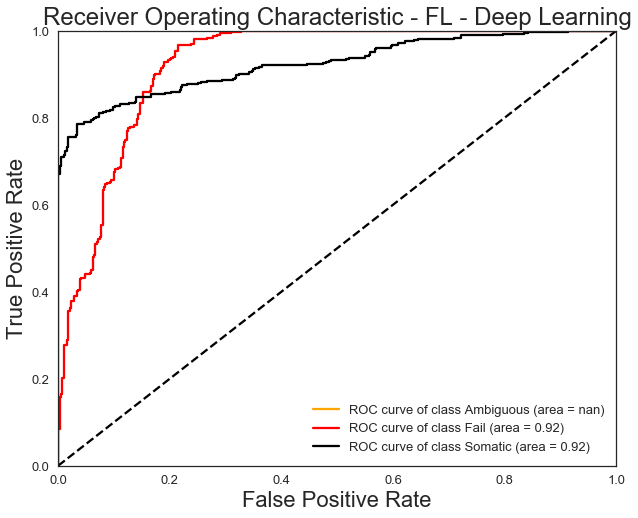

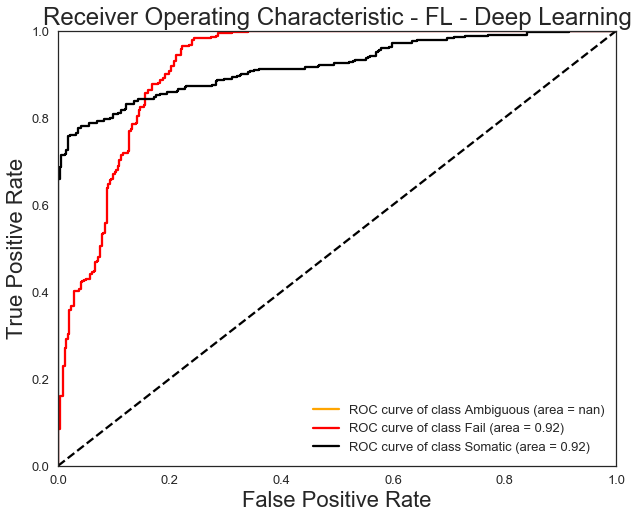

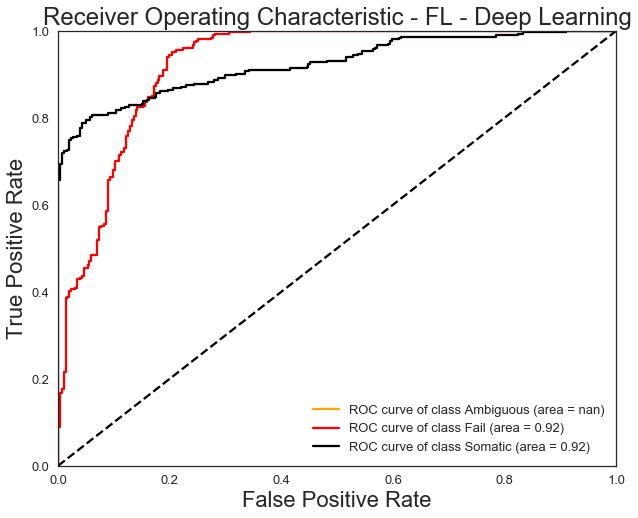

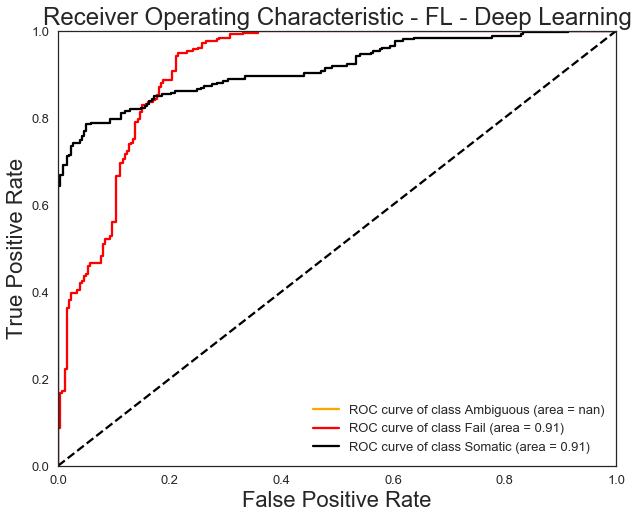

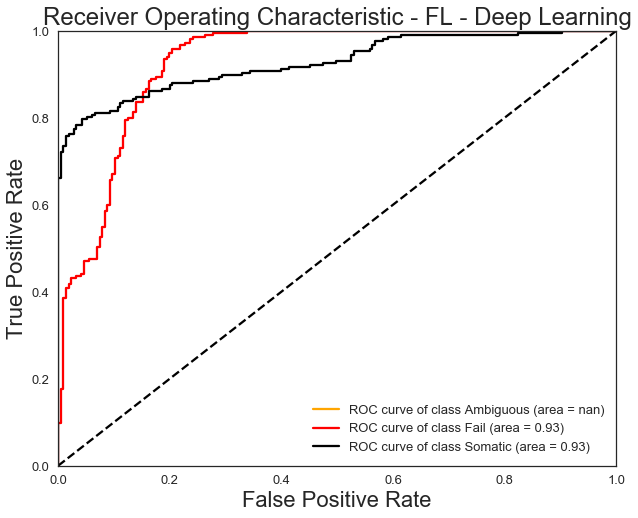

In [43]:
seed = 7
auc = []

for i in np.arange(0, 0.8, 0.05):
    if i == 0:
        fl_X_fl = fl_X
        fl_Y_fl = fl_Y
        X_train = X
        Y_train = Y
    else:
        (fl_X_train, fl_X_fl, fl_Y_train, fl_Y_fl) = train_test_split(fl_X, fl_Y, 
                                                       train_size=i,
                                                       random_state=seed, 
                                                       stratify=fl_Y) 
        X_train = np.concatenate((X, fl_X_train))
        Y_train = np.concatenate((Y, fl_Y_train))
    print('Percentage of fl data included in training: ', i*100)
    print('Training data shape: ', X_train.shape)
    print('Fl data shape: ', fl_X_fl.shape)
    print('Number of FL variants included in training: ', X_train.shape[0]-X.shape[0])
    estimator.fit(X_train, Y_train)
    X_fl_probs = estimator.predict_proba(fl_X_fl)
    
    class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
    fig, ax = plt.subplots()
    create_roc_curve(fl_Y_fl, X_fl_probs, class_lookup, 
                     'Receiver Operating Characteristic - FL - Deep Learning', ax)
    ax.set_ylabel('True Positive Rate', fontsize=22)
    ax.set_xlabel('False Positive Rate', fontsize=22)
    ax.set_title('Receiver Operating Characteristic - FL - Deep Learning', fontsize=24)
    fig.set_size_inches(10, 8)
    savefig('/Users/ebarnell/Desktop/Illustrator/figures/Classifier/ROC/FL_ROC' + str(i) + '.png', bbox_inches='tight', dpi=400)
#     print_accuracy_and_classification_report(fl_Y_fl, predict_classes(X_fl_probs))
#     temp_auc = []    
#     for j in range(Y.shape[1]):
#         temp_auc.append([X_train.shape[0]-X.shape[0], 0, 'fail','somatic'])
#     auc.append(temp_auc)
#     print('Test AUC: ', temp_auc)
    print('---------------------------------------------------------')

In [56]:
fl_auc = [[0, 0, 0.89, 0.891], [86, 0, 0.9, 0.91], [172, 0, 0.84, 0.841], [258, 0, 0.94, 0.914], [344, 0, 0.89, 0.891], 
         [430, 0, 0.92, 0.921], [516, 0, 0.96, 0.961], [603, 0, 0.91, 0.911], [689, 0, 0.91, 0.911], [775, 0, 0.91, 0.911], [861, 0, 0.92, 0.92],
         [861, 0, 0.92, 0.921], [947, 0, 0.92, 0.921], [1033, 0, 0.92, 0.921], [1119, 0, 0.91, 0.911], [1292, 0, 0.94, 0.941]]
fl_auc = pd.DataFrame(fl_auc, columns=['num. FL variants in training','ambiguous', 'fail','somatic'])
fl_auc.to_pickle('../data/deep_learning/fl_batch_effect_correction.pkl')

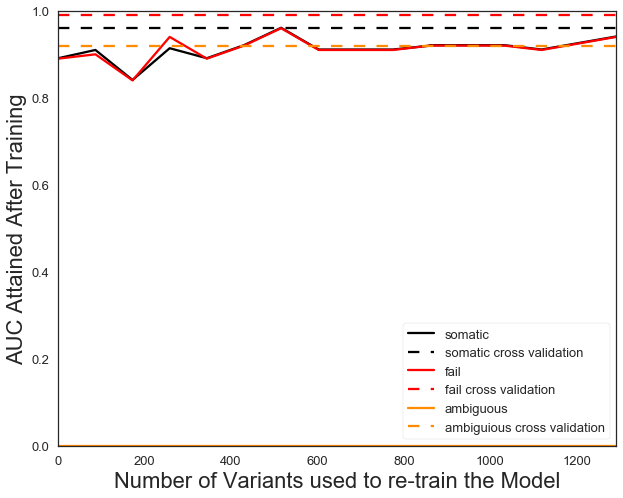

In [57]:
# fl_auc = pd.read_pickle('../data/deep_learning/fl_batch_effect_correction.pkl')
fl_auc = pd.DataFrame(fl_auc, columns=['num. FL variants in training','ambiguous', 'fail','somatic'])
# fl_auc.to_pickle('../data/deep_learning/fl_batch_effect_correction.pkl')
fig, ax = plt.subplots(1, 1)
fl_auc.plot(x='num. FL variants in training', y='somatic', ax=ax, color='black')
ax.plot([0, 1292], [.96,.96], linestyle='--', dashes=(5, 5),color='black', label='somatic cross validation')
fl_auc.plot(x='num. FL variants in training', y='fail', ax=ax, color='red')
ax.plot([0, 1292], [.99,.99], linestyle='--', dashes=(5, 5),color='red', label='fail cross validation')
fl_auc.plot(x='num. FL variants in training', y='ambiguous', ax=ax, color='darkorange')
ax.plot([0, 1292], [.92,.92], linestyle='--', dashes=(5, 5),color='darkorange', label='ambiguious cross validation')
ax.set_ylim([0,1.0])
ax.set_ylabel('AUC Attained After Training', fontsize=22)
ax.set_xlabel('Number of Variants used to re-train the Model', fontsize=22)
ax.set_title('', fontsize=24)
ax.legend(loc=4,frameon=True)
fig.set_size_inches(10, 8)
savefig('/Users/ebarnell/Desktop/Illustrator/figures/Classifier/FL_batch.png', bbox_inches='tight', dpi=1000)

# OSCC

In [40]:
oscc_data = pd.read_pickle('../data/independent_test/oscc_train.pkl')
oscc_data = oscc_data.drop(['disease_OSCC'], axis=1)
oscc_data = oscc_data.drop(['reviewer_NA'], axis=1)
oscc_data['solid_tumor'] = 1

In [41]:
oscc_call = pd.read_pickle('../data/independent_test/oscc_call.pkl')
oscc_call = oscc_call.map(str.lower).replace('g','f').replace('s\x03', 's').replace('', 'f')
oscc_call.value_counts()

f    6891
s    1986
a    293 
Name: call, dtype: int64

In [42]:
# Get Labels
oscc_Y = pd.get_dummies(oscc_call).astype(float).values
# Get training data as numpy array
oscc_X = oscc_data.sort_index(axis=1).astype(float).values

In [43]:
oscc_probs = estimator.predict_proba(oscc_X)

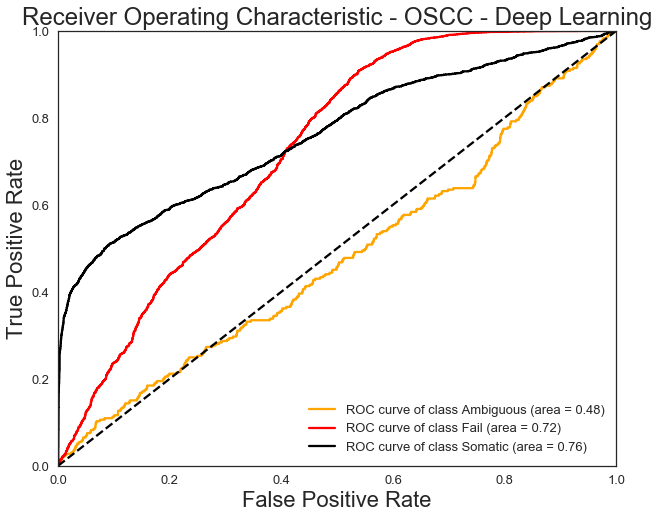

In [44]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(oscc_Y, oscc_probs, class_lookup, 
                 'Receiver Operating Characteristic - OSCC - Deep Learning', ax)
ax.set_ylabel('True Positive Rate', fontsize=22)
ax.set_xlabel('False Positive Rate', fontsize=22)
ax.set_title('Receiver Operating Characteristic - OSCC - Deep Learning', fontsize=24)
fig.set_size_inches(10, 8)
savefig('/Users/ebarnell/Desktop/Illustrator/figures/Classifier/OSCC_ROC.png', bbox_inches='tight', dpi=1000)

In [45]:
seed = 7
auc = []

for i in np.arange(0, 0.8, 0.05):
    if i == 0:
        oscc_X_oscc = oscc_X
        oscc_Y_oscc = oscc_Y
        X_train = X
        Y_train = Y
    else:
        (oscc_X_train, oscc_X_oscc, 
         oscc_Y_train, oscc_Y_oscc) = train_test_split(oscc_X, oscc_Y, 
                                                       train_size=i,
                                                       random_state=seed, 
                                                       stratify=oscc_Y) 
        X_train = np.concatenate((X, oscc_X_train))
        Y_train = np.concatenate((Y, oscc_Y_train))
    print('Percentage of oscc data included in training: ', i*100)
    print('Training data shape: ', X_train.shape)
    print('OSCC data shape: ', oscc_X_oscc.shape)
    print('Number of OSCC variants included in training: ', X_train.shape[0]-X.shape[0])
    estimator.fit(X_train, Y_train)
    X_oscc_probs = estimator.predict_proba(oscc_X_oscc)
    print_accuracy_and_classification_report(oscc_Y_oscc, predict_classes(X_oscc_probs))
    temp_auc = []
    temp_auc.append(X_train.shape[0]-X.shape[0])
    for j in range(Y.shape[1]):
        temp_auc.append(metrics.roc_auc_score(oscc_Y_oscc[:, j], X_oscc_probs[:, j]))
    auc.append(temp_auc)
    print('Test AUC: ', temp_auc)
    print('---------------------------------------------------------')

Percentage of oscc data included in training:  0.0
Training data shape:  (41832, 59)
OSCC data shape:  (9170, 59)
Number of OSCC variants included in training:  0
Cross validation accuracy:
	 0.445801526718

Cross validation classification report

             precision    recall  f1-score   support

          0       0.03      0.13      0.05       293
          1       0.88      0.35      0.50      6891
          2       0.31      0.83      0.45      1986

avg / total       0.73      0.45      0.48      9170

Test AUC:  [0, 0.47149226766568197, 0.74706937570922738, 0.78360750335870022]
---------------------------------------------------------


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Percentage of oscc data included in training:  5.0
Training data shape:  (42290, 59)
OSCC data shape:  (8712, 59)
Number of OSCC variants included in training:  458
Cross validation accuracy:
	 0.528007346189

Cross validation classification report

             precision    recall  f1-score   support

          0       0.02      0.09      0.03       278
          1       0.86      0.48      0.61      6547
          2       0.41      0.78      0.53      1887

avg / total       0.74      0.53      0.58      8712

Test AUC:  [458, 0.4373949737530346, 0.76624027153455332, 0.83444962739080386]
---------------------------------------------------------
Percentage of oscc data included in training:  10.0
Training data shape:  (42749, 59)
OSCC data shape:  (8253, 59)
Number of OSCC variants included in training:  917
Cross validation accuracy:
	 0.492790500424

Cross validation classification report

             precision    recall  f1-score   support

          0       0.03      0.46      0.

/Users/ebarnell/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118675). Check your callbacks.
  % delta_t_median)


Cross validation accuracy:
	 0.82878953108

Cross validation classification report

             precision    recall  f1-score   support

          0       0.05      0.15      0.07       117
          1       0.90      0.94      0.92      2756
          2       0.98      0.54      0.69       795

avg / total       0.89      0.83      0.84      3668

Test AUC:  [5502, 0.59584997123718608, 0.86496607083747112, 0.89462201761356541]
---------------------------------------------------------
Percentage of oscc data included in training:  65.0
Training data shape:  (47792, 59)
OSCC data shape:  (3210, 59)
Number of OSCC variants included in training:  5960
Cross validation accuracy:
	 0.818691588785

Cross validation classification report

             precision    recall  f1-score   support

          0       0.05      0.17      0.08       103
          1       0.91      0.92      0.91      2412
          2       0.97      0.58      0.72       695

avg / total       0.89      0.82      0.84 

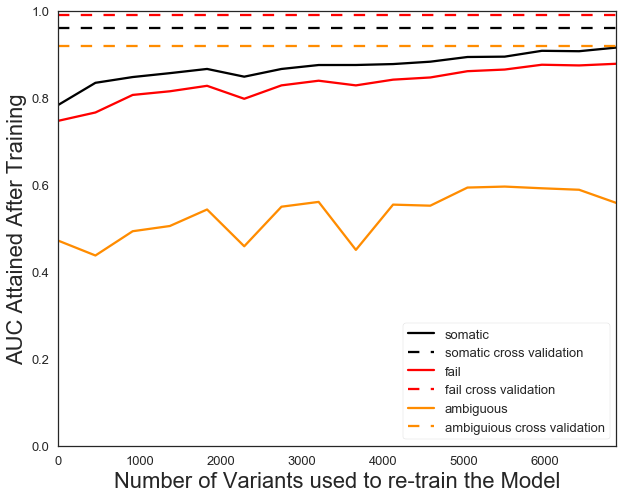

In [46]:
oscc_auc = pd.DataFrame(auc, columns=['num. OSCC variants in training','ambiguous', 'fail','somatic'])
oscc_auc.to_pickle('../data/deep_learning/oscc_batch_effect_correction.pkl')
fig, ax = plt.subplots(1, 1)
oscc_auc.plot(x='num. OSCC variants in training', y='somatic', ax=ax, color='black')
ax.plot([0, 6877], [.96,.96], linestyle='--', dashes=(5, 5),color='black', label='somatic cross validation')
oscc_auc.plot(x='num. OSCC variants in training', y='fail', ax=ax, color='red')
ax.plot([0, 6877], [.99,.99], linestyle='--', dashes=(5, 5),color='red', label='fail cross validation')
oscc_auc.plot(x='num. OSCC variants in training', y='ambiguous', ax=ax, color='darkorange')
ax.plot([0, 6877], [.92,.92], linestyle='--', dashes=(5, 5),color='darkorange', label='ambiguious cross validation')
ax.set_ylim([0,1.0])
ax.set_ylabel('AUC Attained After Training', fontsize=22)
ax.set_xlabel('Number of Variants used to re-train the Model', fontsize=22)
ax.set_title('', fontsize=24)
ax.legend(loc=4,frameon=True)
fig.set_size_inches(10, 8)
savefig('/Users/ebarnell/Desktop/Illustrator/figures/Classifier/OSCC_batch.png', bbox_inches='tight', dpi=1000)